In [ ]:
# Step 1: Scraping the reviews mentioning ecosystem off of BestBuy
# Randomly scraping 150 reviews from across the board

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import numpy as np
from datetime import datetime
import pandas as pd
import seaborn as sns
import plotly.express as px
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import os
from os import path
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
total_pages = 3465
# We can scrape 140 random pages and randomly pull two reviews each from each scraped page
import random
random.seed(9001)
pages_to_be_scraped = [random.randint(1, total_pages+1) for _ in range(140)]
print(len(pages_to_be_scraped))
print(pages_to_be_scraped[:10])

140
[152, 1236, 1037, 280, 2311, 1028, 2332, 3358, 2483, 2102]


In [ ]:
# Scraping
base_url = "https://www.bestbuy.com/site/reviews/apple-airpods-with-charging-case-2nd-generation-white/6084400?variant=A&page={}"

header = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:79.0) Gecko/20100101 Firefox/79.0'}

raw_data = []
total_pages = len(pages_to_be_scraped)

# Create a tqdm progress bar for the loop
for page_number in tqdm(pages_to_be_scraped, desc="Scraping Progress", ncols=100, ascii=True, total=total_pages):
    url = base_url.format(page_number)

    # Send a GET request to the URL
    response = requests.get(url, headers=header)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')
    if 'access' and 'denied' in str(soup).lower():
        print("Stopping the loop.")
        break

    raw_data.append(soup)

    # Add a delay to avoid overwhelming the server with requests
    time.sleep(round(random.uniform(0.1, 3), 2))

# The scraping is completed, and the progress bar is at 100%
print("Scraping completed!")


Scraping Progress: 100%|##########################################| 140/140 [07:47<00:00,  3.34s/it]

Scraping completed!


In [ ]:
date_format = "%b %d, %Y %I:%M %p"
def extract_review_data(data, pages):
    review_page_number = []
    ratings = []
    title = []
    posting_date = []
    used_for = []
    review_body = []
    whether_recommended = []

    for idx, soup in enumerate(data, start = 0):
      review_box = soup.find_all('li', class_='review-item')
      review_page_number.extend([pages[idx]] * len(review_box))
      for review in review_box:
          ratings.append(int(review.find('div', class_='c-ratings-reviews').find('p', class_='visually-hidden').text.replace('Rated ', '').replace(' out of 5 stars', '')))
          title.append(review.find('h4', class_='c-section-title review-title heading-5 v-fw-medium').text)
          date_string = review.find('time', class_='submission-date')['title']
          posting_date.append(datetime.strptime(date_string, date_format))
          try:
              used_for.append(review.find('div', class_='posted-date-ownership').get_text(strip=True).split("Owned for")[1].split("when reviewed.")[0])
          except:
              used_for.append('Not Available')
          review_body.append(review.find('div', class_='ugc-review-body').find('p').text.strip())
          recommendation_text = review.find('div', class_='ugc-recommendation').get_text(strip=True)
          if "wouldrecommend" in recommendation_text:
              whether_recommended.append(1)
          elif "wouldnot" in recommendation_text:
              whether_recommended.append(0)
          else:
              whether_recommended.append('Not Available')
    return {
        'Review_Page_Number': review_page_number,
        'Ratings': ratings,
        'Title': title,
        'Posting_Date': posting_date,
        'Used_For': used_for,
        'Review_Body': review_body,
        'Whether_Recommended': whether_recommended
    }

In [ ]:
review_samples = extract_review_data(raw_data, pages_to_be_scraped)
print(len(review_samples))

7


In [ ]:
# Create a dataframe with all the reviews
df_samples = pd.DataFrame(review_samples)
df_samples.head()

,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,152,5,Apple ear pod.,2023-06-30 18:16:00,1 month,These ear pods are great and work for prefect....,1
1,152,5,Airpods,2023-07-26 12:36:00,2 weeks,"I love that airpods, this ones are my second p...",1
2,152,5,Sue's Pods,2023-06-30 14:54:00,6 months,Love them. Just have to be careful to not loos...,1
3,152,5,Air pods,2023-06-19 10:11:00,1 year,I love the air pods. My grandson said: nana. t...,1
4,152,5,Airpods,2023-07-20 20:37:00,1 month,What can i say. There airpods not much to day ...,0


In [ ]:
df_samples.to_csv('all_reviews.csv')

In [ ]:
# Scraping the reviews with ecosystem mentioned
base_url_2 = 'https://www.bestbuy.com/site/reviews/apple-airpods-with-charging-case-2nd-generation-white/6084400?variant=A&searchText=ecosystem%20OR%20eco-system%20OR%20echo%20system%20OR%20eco%20system&sort=BEST_MATCH&page={}'
header = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:79.0) Gecko/20100101 Firefox/79.0'}

raw_data_2 = []
pages_to_be_scraped_2 = range(1,15)
total_pages = len(pages_to_be_scraped_2)

# Create a tqdm progress bar for the loop
for page_number in tqdm(pages_to_be_scraped_2, desc="Scraping Progress", ncols=100, ascii=True, total=total_pages):
    url = base_url_2.format(page_number)

    # Send a GET request to the URL
    response = requests.get(url, headers=header)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')
    if 'access' and 'denied' in str(soup).lower():
        print("Stopping the loop.")
        break

    raw_data_2.append(soup)

    # Add a delay to avoid overwhelming the server with requests
    time.sleep(round(random.uniform(0.1, 3), 2))

# The scraping is completed, and the progress bar is at 100%
print("Scraping completed!")


Scraping Progress: 100%|############################################| 14/14 [00:43<00:00,  3.13s/it]

Scraping completed!


In [ ]:
review_ecosystem = extract_review_data(raw_data_2, pages_to_be_scraped_2)
print(len(review_ecosystem))

7


In [ ]:
# Create a dataframe with all the reviews
df_ecosystem = pd.DataFrame(review_ecosystem)
print(len(df_ecosystem))
df_ecosystem.head()

263


,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,1,5,Apple eco system,2021-06-06 16:48:00,1 year,Great product. Yes it may not be the best but ...,1
1,1,2,Pay for the EcoSystem,2021-08-06 15:37:00,3 weeks,For the money there are better options . Other...,1
2,1,4,Great for the Apple Eco-System,2021-11-18 18:04:00,3 months,Solid product to go with the Apple eco-system....,1
3,1,4,Great set for the Apple eco system,2020-01-06 14:26:00,3 weeks,They are just what you would expect from an Ap...,1
4,1,5,Best airpod,2023-07-06 18:41:00,2 months,Best airpod 2 gen really good works with apple...,1


In [ ]:
df_ecosystem.to_csv('all_eco_system_reviews.csv')

In [ ]:
df_ecosystem[df_ecosystem['Review_Body'].str.contains('If you are part of the Apple eco system thes')]

,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
15,1,5,Works seemlessly,2019-10-19 21:32:00,3 weeks,If you are part of the Apple eco system these ...,1


In [ ]:
# Pruning samples down to 263 items
# Logic for selection - I have 140 sets of 20 reviews each. I want to be as widespread with my selection as possible to minimise clusters of reviews.
# So, I will go with 1 unique review picked from 17 pages, and 2 reviews picked from 123 pages
# Count the number of reviews from each pagerandom.seed(22)
# Randomly select 17 unique pages and other pages
unique_pages = random.sample(pages_to_be_scraped, 17)
other_pages = [item for item in pages_to_be_scraped if item not in unique_pages]

def samples(group):
    number = 2 if group.name in other_pages else 1
    return group.sample(n=min(number, len(group)), random_state=22)

# Group the DataFrame by 'Review_Page_Number' and sample reviews from each group
df_samples_subset = df_samples.groupby('Review_Page_Number', group_keys=False, sort=False).apply(samples)
remaining_samples = 263 - len(df_samples_subset)
additional_samples = df_samples.sample(n=remaining_samples, random_state=22)
df_samples_subset = pd.concat([df_samples_subset, additional_samples], ignore_index=True)

print(len(df_samples_subset))
df_samples_subset.head()


263


,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,152,5,Great,2023-06-28 13:22:00,7 months,Was great for i need. I lost my onld one and t...,1
1,152,5,Solid purchase!,2023-06-03 04:40:00,3 weeks,Easily syncs to both my iPhone and Mac almost ...,1
2,1236,5,I brought for my sister,2020-07-26 17:10:00,2 weeks,I got these for my sister for her birthday and...,1
3,1236,5,good buy,2020-11-23 23:47:00,4 months,gifted them to a friend and she loves using th...,1
4,1037,5,Power in my ear!,2021-02-20 01:07:00,Not Available,"Love my headphones, literally go everywhere wi...",1


In [ ]:
len(df_samples_subset.drop_duplicates())

263

In [ ]:
len(df_ecosystem.drop_duplicates())

263

In [ ]:
# Exploratory Data Analysis 1
# Average Ratings
samples_rating = df_samples_subset['Ratings'].value_counts().reset_index()
samples_rating['Nature'] = np.repeat('Random Samples', len(samples_rating))
ecosystem_rating = df_ecosystem['Ratings'].value_counts().reset_index()
ecosystem_rating['Nature'] = np.repeat('Ecosystem Reviews', len(ecosystem_rating))
df_rating = pd.concat([samples_rating, ecosystem_rating])
df_rating

,index,Ratings,Nature
0,5,235,Random Samples
1,4,22,Random Samples
2,1,2,Random Samples
3,2,2,Random Samples
4,3,2,Random Samples
0,5,202,Ecosystem Reviews
1,4,50,Ecosystem Reviews
2,3,8,Ecosystem Reviews
3,2,2,Ecosystem Reviews
4,1,1,Ecosystem Reviews


In [ ]:
df_samples['Ratings'].mean()

4.826071428571429

In [ ]:
df_ecosystem['Ratings'].mean()

4.7110266159695815

In [ ]:
fig = px.bar(df_rating, x="Nature", y=["Ratings"], color= 'index', title="Apple AirPods User Rating", width=600, labels={"value": "Review Counts", 'variable': 'Selection'})
fig.update_traces(marker_line_width=0)  # Remove bar borders
fig.update_layout(title_x=0.5)
fig.update_traces(width=.5)
fig.show()

In [ ]:
# EDA 2: Word count plot

In [ ]:
# Cleaning pipeline
def cleaning(x):
    x = " ".join(x.split())
    x = str(x).lower()
    return x

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

stops = set(stopwords.words('english'))
new_stopwords = ['like', 'one', "cant", "really", 'said', 'get', 'went', 'even', 'told', 'could', 'apple', 'would', 'see', "thats", "im", "i m", 'got', 'airpods', 'good', 'great', 'love', 'loves']
stops = stops.union(new_stopwords)

# Lemmatizing each row of the cleaned text
# Function
# Lemmatizing and Tokenizing
lemmatizer = WordNetLemmatizer()
def lemm(x):
    removed_stop_lemma = []
    tokens1 = word_tokenize(x)
    for i in range(len(tokens1)):
        removed_stop_lemma.append(lemmatizer.lemmatize(tokens1[i]))
    toto = " ".join(removed_stop_lemma)
    return toto

def clean_pipeline(text):
    # Converting text to lowercase
    text = cleaning(text)
    # Punctuation
    text = remove_punctuation(text)
    # Stop words
    text = ' '.join("" if p in stops else p for p in text.split())
    # Lemmatizing the text
    text = lemm(text)
    text = ' '.join("" if i in stops else i for i in text.split())
    return text

In [ ]:
# Cleaned reviews
tqdm.pandas()
df_samples_subset['text_cleaned'] = df_samples_subset['Review_Body'].progress_apply(lambda x: clean_pipeline(x))
df_ecosystem['text_cleaned'] = df_ecosystem['Review_Body'].progress_apply(lambda x: clean_pipeline(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


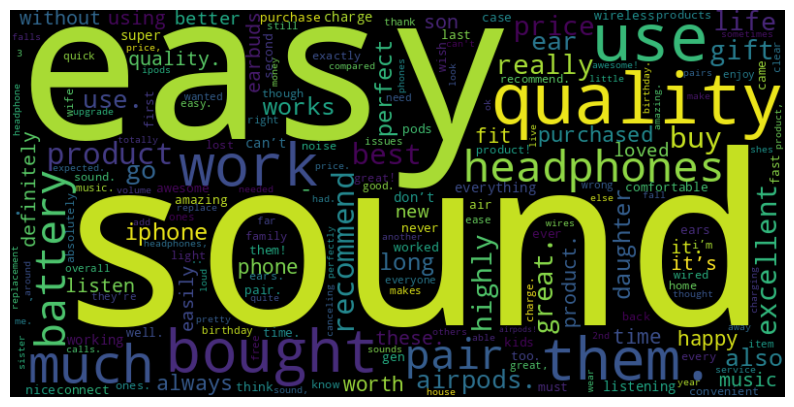

In [ ]:
# Convert each sentence to lowercase and drop punctuation
df_count = pd.DataFrame(list(df_samples_subset['Review_Body']))
df_count = df_count.apply(lambda x: x.astype(str).str.lower())

# Counting most common words
from collections import Counter
counts = Counter(" ".join(df_count[0]).split()).most_common(1000)
counts
countsdf= pd.DataFrame(counts)

# Tokenizing words
wostop = []
words = countsdf[0]
stops = set(stopwords.words('english'))
new_stopwords = ['iphone', 'like', 'one', 'said', 'get', 'went', 'even', 'told', 'could', 'apple', 'would', 'see', "that's", "i'm", "i 'm", 'got', 'airpods', 'good', 'great', 'love', 'loves']
stops = stops.union(new_stopwords)
for line in words:
    if line not in stops:
        wostop.append(line)

# Creating a dataframe of counts of words
countsdf1 = countsdf[countsdf[0].isin(wostop)]
countsdf1

# Plotting word frequency plot
dataplot = dict(zip(countsdf1[0].tolist(), countsdf1[1].tolist()))

# Generate a word cloud image
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dataplot)

# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


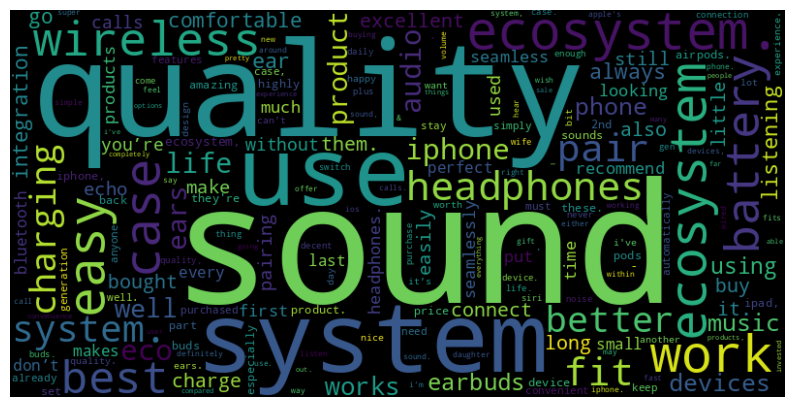

In [ ]:
# Importing packages
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import os
from os import path
from wordcloud import WordCloud

# Convert each sentence to lowercase and drop punctuation
df_count = pd.DataFrame(list(df_ecosystem['Review_Body']))
df_count = df_count.apply(lambda x: x.astype(str).str.lower())

# Counting most common words
from collections import Counter
counts = Counter(" ".join(df_count[0]).split()).most_common(1000)
counts
countsdf= pd.DataFrame(counts)

# Tokenizing words
wostop = []
words = countsdf[0]
stops = set(stopwords.words('english'))
new_stopwords = ['like', 'one', "can't", "cant", "really", "great.", 'said', 'get', 'went', 'even', 'told', 'could', 'apple', 'would', 'see', "that's", "i'm", "i 'm", 'got', 'airpods', 'good', 'great', 'love', 'loves']
stops = stops.union(new_stopwords)
for line in words:
    if line not in stops:
        wostop.append(line)

# Creating a dataframe of counts of words
countsdf1 = countsdf[countsdf[0].isin(wostop)]
countsdf1

# Plotting word frequency plot
dataplot = dict(zip(countsdf1[0].tolist(), countsdf1[1].tolist()))

# Generate a word cloud image
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dataplot)

# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Exploring the most common words used in both sets of reviews, and creating a correlation matrix


In [ ]:
import plotly.graph_objects as go

import pandas as pd

# Load dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")
df.columns = [col.replace("AAPL.", "") for col in df.columns]

# Initialize figure
fig = go.Figure()

# Add Traces

fig.add_trace(
    go.Scatter(x=list(df.Date),
               y=list(df.High),
               name="High",
               line=dict(color="#33CFA5")))

fig.add_trace(
    go.Scatter(x=list(df.Date),
               y=[df.High.mean()] * len(df.index),
               name="High Average",
               visible=False,
               line=dict(color="#33CFA5", dash="dash")))

fig.add_trace(
    go.Scatter(x=list(df.Date),
               y=list(df.Low),
               name="Low",
               line=dict(color="#F06A6A")))

fig.add_trace(
    go.Scatter(x=list(df.Date),
               y=[df.Low.mean()] * len(df.index),
               name="Low Average",
               visible=False,
               line=dict(color="#F06A6A", dash="dash")))

# Add Annotations and Buttons
high_annotations = [dict(x="2016-03-01",
                         y=df.High.mean(),
                         xref="x", yref="y",
                         text="High Average:<br> %.3f" % df.High.mean(),
                         ax=0, ay=-40),
                    dict(x=df.Date[df.High.idxmax()],
                         y=df.High.max(),
                         xref="x", yref="y",
                         text="High Max:<br> %.3f" % df.High.max(),
                         ax=-40, ay=-40)]
low_annotations = [dict(x="2015-05-01",
                        y=df.Low.mean(),
                        xref="x", yref="y",
                        text="Low Average:<br> %.3f" % df.Low.mean(),
                        ax=0, ay=40),
                   dict(x=df.Date[df.High.idxmin()],
                        y=df.Low.min(),
                        xref="x", yref="y",
                        text="Low Min:<br> %.3f" % df.Low.min(),
                        ax=0, ay=40)]

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="None",
                     method="update",
                     args=[{"visible": [True, False, True, False]},
                           {"title": "Yahoo",
                            "annotations": []}]),
                dict(label="High",
                     method="update",
                     args=[{"visible": [True, True, False, False]},
                           {"title": "Yahoo High",
                            "annotations": high_annotations}]),
                dict(label="Low",
                     method="update",
                     args=[{"visible": [False, False, True, True]},
                           {"title": "Yahoo Low",
                            "annotations": low_annotations}]),
                dict(label="Both",
                     method="update",
                     args=[{"visible": [True, True, True, True]},
                           {"title": "Yahoo",
                            "annotations": high_annotations + low_annotations}]),
            ]),
        )
    ])

# Set title
fig.update_layout(title_text="Yahoo")

fig.show()

In [ ]:
subset_tfidf_scores

,disappointed,experience,great,recommend,recommended,terrible,worst
0,0.000000,0.00000,0.568014,0.00000,0.568014,0.00000,0.000000
1,0.000000,0.57735,0.000000,0.57735,0.000000,0.57735,0.000000
2,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
3,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
4,0.568014,0.00000,0.000000,0.00000,0.000000,0.00000,0.568014


In [ ]:
# # Ignore
# # Get required data
# date_format = "%b %d, %Y %I:%M %p"
# review_page_number = []
# ratings = []
# title = []
# posting_date = []
# used_for = []
# review_body = []
# whether_recommended = []
# for idx, soup in enumerate(raw_data, start=0):
#   review_page_number.append(np.repeat(pages_to_be_scraped[idx], 20))
#   review_box = soup.find_all('li', class_='review-item')
#   for review in review_box:
#     ratings.append(int(review.find('div', class_='c-ratings-reviews').find('p', class_='visually-hidden').text.replace('Rated ', '').replace(' out of 5 stars', '')))
#     title.append(review.find('h4', class_='c-section-title review-title heading-5 v-fw-medium').text)
#     date_string = review.find('time', class_='submission-date')['title']
#     posting_date.append(datetime.strptime(date_string, date_format))
#     try:
#       used_for.append(review.find('div', class_='posted-date-ownership').get_text(strip=True).split("Owned for")[1].split("when reviewed.")[0])
#     except:
#       used_for.append('Not Available')
#     review_body.append(review.find('div', class_='ugc-review-body').find('p').text.strip())
#     recommendation_text = review.find('div', class_='ugc-recommendation').get_text(strip=True)
#     if "wouldrecommend" in recommendation_text:
#         whether_recommended.append(1)
#     elif "wouldnot" in recommendation_text:
#         whether_recommended.append(0)
#     else:
#         whether_recommended.append('Not Available')
# review_page_number = [item for sublist in review_page_number for item in sublist]

In [ ]:
# # Get required data
# pages_to_be_scraped_2 = range(1,15)
# date_format = "%b %d, %Y %I:%M %p"
# review_page_number_2 = []
# ratings_2 = []
# title_2 = []
# posting_date_2 = []
# used_for_2 = []
# review_body_2 = []
# whether_recommended_2 = []
# for idx, soup in enumerate(raw_data_2, start=0):
#   review_page_number_2.append(np.repeat(pages_to_be_scraped_2[idx], 20))
#   review_box = soup.find_all('li', class_='review-item')
#   for review in review_box:
#     ratings_2.append(int(review.find('div', class_='c-ratings-reviews').find('p', class_='visually-hidden').text.replace('Rated ', '').replace(' out of 5 stars', '')))
#     title_2.append(review.find('h4', class_='c-section-title review-title heading-5 v-fw-medium').text)
#     date_string_2 = review.find('time', class_='submission-date')['title']
#     posting_date_2.append(datetime.strptime(date_string, date_format))
#     try:
#       used_for_2.append(review.find('div', class_='posted-date-ownership').get_text(strip=True).split("Owned for")[1].split("when reviewed.")[0])
#     except:
#       used_for_2.append('Not Available')
#     review_body_2.append(review.find('div', class_='ugc-review-body').find('p').text.strip())
#     recommendation_text_2 = review.find('div', class_='ugc-recommendation').get_text(strip=True)
#     if "wouldrecommend" in recommendation_text_2:
#         whether_recommended_2.append(1)
#     elif "wouldnot" in recommendation_text_2:
#         whether_recommended_2.append(0)
#     else:
#         whether_recommended_2.append('Not Available')
# review_page_number_2 = [item for sublist in review_page_number_2 for item in sublist]